In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re
import TextNLP

In [2]:
yelp_data = pd.read_csv("yelp_dataset.csv",)
yelp_data.isnull().values.any()

False

In [3]:
def runNLP(data):
    X=[]
    nlpText = TextNLP.TextNLP()
    for i , _ in enumerate(data):
        data[i] = nlpText.prepareData(data[i])
        data[i] = nlpText.slang(data[i])
        data[i] = nlpText.removeStopWords(data[i])
        data[i] = nlpText.stemmAndLemmatization(data[i])
        data[i] = nlpText.removepunctuations(data[i])
        X.append(data[i])
    return X

In [5]:
sentences = list(yelp_data["text"])
X = runNLP(sentences)

y = yelp_data['reviews_score']

In [6]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y = label_encoder.fit_transform(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [9]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train) 
X_test = tokenizer.texts_to_sequences(X_test)

In [10]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [11]:
from numpy import array
from numpy import asarray
from numpy import zeros

glove_file = open('glove.6B.100d.txt', encoding="utf8")

embeddings_dictionary = dict()

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [12]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [13]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(3, activation='softmax')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [14]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          31706900  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 31,824,535
Trainable params: 117,635
Non-trainable params: 31,706,900
_________________________________________________________________
None


In [15]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
7500/7500 [==============================] - 3137s 415ms/step - loss: 0.7113 - acc: 0.7170 - val_loss: 0.3874 - val_acc: 0.8394
Epoch 2/10
7500/7500 [==============================] - 3022s 403ms/step - loss: 0.3772 - acc: 0.8438 - val_loss: 0.3472 - val_acc: 0.8565
Epoch 3/10
7500/7500 [==============================] - 3023s 403ms/step - loss: 0.3412 - acc: 0.8599 - val_loss: 0.3361 - val_acc: 0.8608
Epoch 4/10
7500/7500 [==============================] - 3041s 405ms/step - loss: 0.3242 - acc: 0.8663 - val_loss: 0.3291 - val_acc: 0.8640
Epoch 5/10
7500/7500 [==============================] - 3025s 403ms/step - loss: 0.3131 - acc: 0.8710 - val_loss: 0.3268 - val_acc: 0.8648
Epoch 6/10
7500/7500 [==============================] - 3034s 405ms/step - loss: 0.3033 - acc: 0.8754 - val_loss: 0.3271 - val_acc: 0.8647
Epoch 7/10
7500/7500 [==============================] - 3026s 403ms/step - loss: 0.2958 - acc: 0.8779 - val_loss: 0.3302 - val_acc: 0.8636
Epoch 8/10
7500/7500 [=====

In [16]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

9375/9375 [==============================] - 659s 70ms/step - loss: 0.3364 - acc: 0.8644
Test Score: 0.3363664448261261
Test Accuracy: 0.8643699884414673


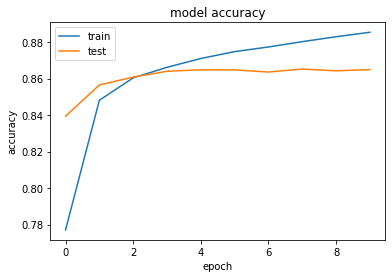

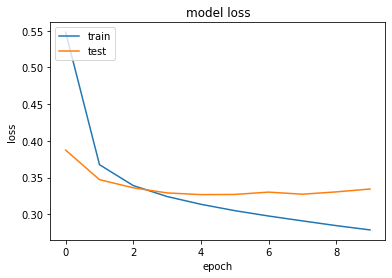

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [26]:
#saving the model
import pickle
model_json = model.to_json()
with open("savedModels/RNN_PreTrained_Word_Embedding.json", "w") as json_file:
    json_file.write(model_json)
#Save weights
model.save_weights("savedModels/RNN_PreTrained_Word_Embedding_Weights.h5")

In [27]:
#Loading the model
from tensorflow.keras.models import model_from_json
json_file = open('savedModels/RNN_PreTrained_Word_Embedding.json', 'r')
loaded_model_json = json_file.read()                    #Load model structure from the json file
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("savedModels/RNN_PreTrained_Word_Embedding_Weights.h5")   # load weights into new model

In [31]:
#Testing the loaded model
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
score = loaded_model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

9375/9375 [==============================] - 718s 74ms/step - loss: 0.3364 - acc: 0.8644
Test Score: 0.3363664448261261
Test Accuracy: 0.8643699884414673
